## Figure 2 - Numerical model

**Author:** Quentin Duez

This notebook builds and analyses a numerical model based on the reaction shown in Figure 2

**Outputs:** Figure 2E and Figure S3

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

sns.set_theme(style="ticks", context="paper")

from SALib.sample import sobol

In [2]:
# One step second order reversible action : A + B <--> C


def d1_2nd_rev_dt(x, t, *args):
    A, B, C = x
    k1, km1, kf = args
    dAdt = (
        -k1 * A * B
        + km1 * C
        + kf * A0_ss * (1 + np.sin(2 * np.pi * t / PERIOD))
        - kf * A
    )
    dBdt = -k1 * A * B + km1 * C + kf * B0_ss - kf * B
    dCdt = k1 * A * B - km1 * C - kf * C
    return dAdt, dBdt, dCdt

In [3]:
# Fitting functions


def sinfunc(t, A, w, p, c):
    return A * np.sin(np.pi * (t - p) / w) + c
    # return A * np.sin(w*t + p) + c


def fit_sin(
    tt, yy, PERIOD
):  # Scooped from https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1] - tt[0]))  # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    # guess_freq = 1./ PERIOD
    # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.0**0.5
    guess_offset = np.mean(yy)
    guess = np.array(
        [guess_amp, PERIOD / 2, 0.0, guess_offset]
    )  # Guess phase = 0; check what works better

    popt, pcov = curve_fit(
        sinfunc,
        tt,
        yy,
        p0=guess,
        bounds=(
            (0, (PERIOD - 0.0001) / 2, -np.inf, -np.inf),
            (np.inf, (PERIOD + 0.0001) / 2, np.inf, np.inf),
        ),
    )
    A, w, p, c = popt
    f = w / (2.0 * np.pi)
    period = w * 2
    fitfunc = lambda t: A * np.sin(np.pi * (t - p) / w) + c
    return {
        "amp": A,
        "omega": w,
        "phase": p,
        "offset": c,
        "freq": f,
        "period": period,
        "fitfunc": fitfunc,
        "maxcov": np.max(pcov),
        "rawres": (guess, popt, pcov),
    }


def fit_sin_CSTR(t, conc, eq_time, PERIOD):
    t_filtered = t[eq_time:]
    conc_filtered = conc[eq_time:]

    res = fit_sin(t_filtered, conc_filtered, PERIOD)
    ypred = sinfunc(t_filtered, res["amp"], res["omega"], res["phase"], res["offset"])
    r2 = r2_score(conc_filtered, ypred)
    # print(r2_score(conc_filtered, ypred))
    phase = res["phase"]
    amp = res["amp"]

    if abs(phase) > PERIOD:
        ntot = abs(phase) / PERIOD
        nunits = ntot // 1
        if nunits > 0:
            coma = ntot - nunits
        else:
            coma = 0
        phase = coma * PERIOD
    else:
        phase = phase

    if r2 > 0.2:  # Condition for not trying to interpret weird data
        rel_amp = (
            abs(res["amp"]) / res["offset"]
        )  # Calculate the amplitude of the oscillation relative to the ion signal

        # Get time delay from the phase (empirically determined, was tricky for me brain)
        if (res["amp"] > 0) & (phase > 0):
            delay = phase + 0.5 * res["omega"]
        elif (res["amp"] > 0) & (phase < 0):
            delay = phase + 2.5 * res["omega"]
        else:
            pass
    else:
        rel_amp = 0
        delay = 0
        phase = 0

    return (rel_amp, delay, r2, phase, amp)


def model_evaluate_2nd_reversible(model, param_values):
    fit_df = pd.DataFrame()
    for i, params in enumerate(param_values):

        klist = params.tolist()
        t = np.linspace(0, 1000, 1001)

        x0 = np.zeros(
            int(len(klist)) + 1
        )  # initial conditions !! Number of compounds different than for nonreversible !!
        x0[0] = 0.001  # Define the concentration of the first compound
        sol = odeint(model, x0, t, args=(*klist, kf))
        num_sol = sol.shape[1]

        s = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
        s = s[:num_sol]

        C_avg = sol[:, 2].mean()
        A_avg = sol[:, 0].mean()

        fit_dict = dict()
        for char in s:
            out = sol[:, s.index(char)]
            fit = fit_sin_CSTR(t, out, eq_time, PERIOD)
            if (fit[2] > 0.5) & (C_avg > 0.01 * A_avg):
                fit_dict.update(
                    {
                        "k1": klist[0],
                        "km1": klist[1],
                        f"rel_amp_{char}": fit[0],
                        f"time_delay_{char}": fit[1],
                    }
                )
            else:
                fit_dict.update(
                    {
                        "k1": klist[0],
                        "km1": klist[1],
                        f"rel_amp_{char}": 1,
                        f"time_delay_{char}": 0,
                    }
                )

        fit_df_temp = pd.DataFrame(fit_dict, index=[0])
        fit_df = pd.concat([fit_df, fit_df_temp])

    return fit_df

In [4]:
# Initial oscillations
A0_ss = 0.001  # mol/L
B0_ss = 0.0004  # mol/L - For 2nd order reactions
TAU = 30  # minutes - Residence time
PERIOD = 120  # min
kf = 1 / TAU  # = flowrate (µL/min)/Reactor volume (µL) = 1/residence time (min)
eq_time = 3 * TAU  # The CSTR should be equilibrated at ~4-5x the residence time

### Second order reversible reaction

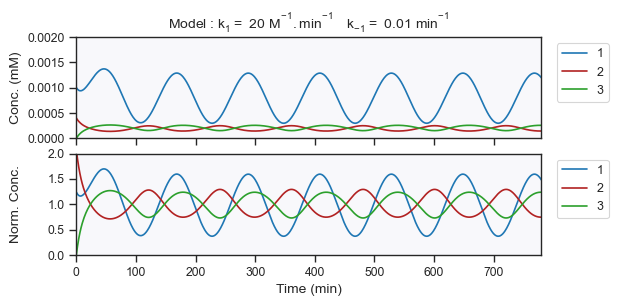

In [5]:
# One step reaction : A + B --> C
# With fixed k1/km1

k1 = 50  # M-1 min-1
km1 = 0.0005  # min-1

t = np.linspace(0, 1000, 1001)
x0 = 0.001, 0.0004, 0  # initial conditions
sol = odeint(d1_2nd_rev_dt, x0, t, args=(k1, km1, kf))

A_overlay = sol[:, 0] / sol[:, 0].mean()
B_overlay = sol[:, 1] / sol[:, 1].mean()
C_overlay = sol[:, 2] / sol[:, 2].mean()

fig, ax = plt.subplots(2, 1, figsize=(6, 2))

params = {"mathtext.default": "regular"}
plt.rcParams.update(params)

sns.lineplot(x=t, y=A_overlay, ax=ax[1], c="tab:blue", label="1")
sns.lineplot(x=t, y=B_overlay, ax=ax[1], c="firebrick", label="2")
sns.lineplot(x=t, y=C_overlay, ax=ax[1], c="tab:green", label="3")
sns.lineplot(x=t, y=sol[:, 0], ax=ax[0], c="tab:blue", label="1")
sns.lineplot(x=t, y=sol[:, 1], ax=ax[0], c="firebrick", label="2")
sns.lineplot(x=t, y=sol[:, 2], ax=ax[0], c="tab:green", label="3")

ax[0].set_ylim(0, 0.002)
ax[1].set_ylim(0, 2)
ax[0].set_xlim(0, 780)
ax[1].set_xlim(0, 780)


ax[0].set_ylabel("Conc. (mM)", fontsize=10)
ax[1].set_ylabel("Norm. Conc.", fontsize=10)
ax[0].set_xlabel("")
ax[1].set_xlabel("Time (min)", fontsize=10)

ax[0].set_xticklabels("")
fig.align_ylabels(ax[:])

ax[0].legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9)
ax[1].legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9)

ax[0].set_facecolor("#F8F8FB")
ax[1].set_facecolor("#F8F8FB")

ax[0].set_title(
    r"Model : $k_{1} =\ 20 \ M^{-1}.min^{-1} \quad k_{-1} =\ 0.01 \ min^{-1}$",
    fontsize=10,
)

plt.subplots_adjust(
    left=None, bottom=None, right=None, top=1.2, wspace=None, hspace=0.15
)
# plt.savefig('Figure1_model.svg', format='svg', bbox_inches='tight', dpi=600)

### Probing the sensitivity of the reaction for k1 and k-1

In [6]:
# Define problem
# EXECUTE ONLY TO REGENERATE ALL THE VALUES, OTHERWISE USE THE FOLLOWING CELL TO READ THE ASSOCIATED EXCEL FILE
problem = {
    "num_vars": 2,
    "names": ["k1", "km1"],
    "bounds": [[5e-2, 1e3], [1e-5, 1e2]],
    "dists": ["logunif", "logunif"],  # Makes logarithmic uniform distribution
}

# Generate parameter samples
param_values = sobol.sample(
    problem, 4096
)  # Sampler generated N * (2D+2) inputs, N = num_samples and D = num_vars
# print(param_values)

fit_df = model_evaluate_2nd_reversible(d1_2nd_rev_dt, param_values)

fit_df["time_delay_AC"] = fit_df["time_delay_C"] - fit_df["time_delay_A"]
fit_df["time_delay_CB"] = fit_df["time_delay_B"] - fit_df["time_delay_C"]

In [6]:
# READ THE ASSOCIATED EXCEL FILE TO AVOID REGENERATING ALL THE VALUES
fit_df = pd.read_excel("data/k1_km1_full.xlsx", index_col=0)
fit_df = fit_df.reset_index()

Text(0, 0.5, '$k_{-1}\\ (min^{-1})$')

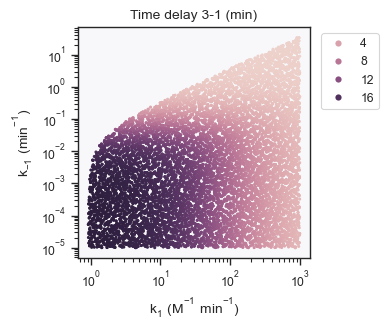

In [7]:
fit_df_pos = fit_df[
    fit_df.time_delay_AC > 0
]  # Since the fitting of concentration time courses deviating from sine waves (R² < 0.98)
# yields time delay = 0, the time_delay_AC is negative (usually - 49 min)
# We thus filter out these data points (see Supplementary Information)

fig, ax = plt.subplots(figsize=(3, 3))
sns.scatterplot(data=fit_df_pos, x="k1", y="km1", hue="time_delay_AC", s=5, linewidth=0)
ax.set_facecolor("#F8F8FB")
ax.legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", markerscale=2)
ax.set_title("Time delay 3-1 (min)", fontsize=10)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$k_{1}\\ (M^{-1}\\ min^{-1})$", fontsize=10)
ax.set_ylabel("$k_{-1}\\ (min^{-1})$", fontsize=10)
# plt.savefig('Figure1_k1_km1.svg', format='svg', bbox_inches='tight', dpi=600)

77.12852713954395 31.51066344820298
0.013478402343273363 0.01978118854301843


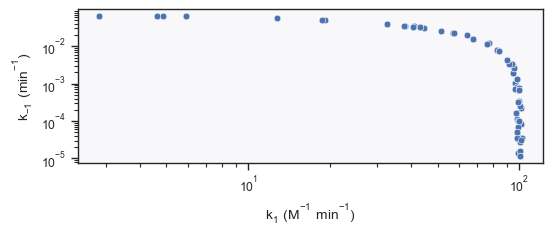

In [8]:
# Check the datapoints where the time delay between A and C matches the experimental value
out_df = fit_df.loc[(fit_df["time_delay_AC"] < 9.2) & (fit_df["time_delay_AC"] > 9.0)]

print(out_df.k1.mean(), out_df.k1.std())
print(out_df.km1.mean(), out_df.km1.std())

fig, ax = plt.subplots(figsize=(6, 2))
sns.scatterplot(out_df, x="k1", y="km1")
ax.set_facecolor("#F8F8FB")
ax.set_xlabel("$k_{1}\\ (M^{-1}\\ min^{-1})$", fontsize=10)
ax.set_ylabel("$k_{-1}\\ (min^{-1})$", fontsize=10)

ax.set_xscale("log")
ax.set_yscale("log")

# plt.savefig('Figure_SI_k1_km1_filtered.svg', format='svg', bbox_inches='tight', dpi=600)